In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import time

warnings.filterwarnings('ignore')

In [25]:
# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [27]:
train_dir = "./train/"
test_dir = "./test/"

emotion_classes = sorted(os.listdir(train_dir))
print(f"\nEmotion classes found: {emotion_classes}")
print(f"Number of classes: {len(emotion_classes)}")


Emotion classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


In [28]:
# get no of images per emotion for train and test images
for emotion in emotion_classes:
    train_count = len(os.listdir(os.path.join(train_dir, emotion)))
    test_count = len(os.listdir(os.path.join(test_dir, emotion)))
    print(f"{emotion}: {train_count} train, {test_count} test images")

angry: 3995 train, 958 test images
disgust: 436 train, 111 test images
fear: 4097 train, 1024 test images
happy: 7215 train, 1774 test images
neutral: 4965 train, 1233 test images
sad: 4830 train, 1247 test images
surprise: 3171 train, 831 test images


In [29]:
# define transforms for training with augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [30]:
# define transforms for testing with no augmentation
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [31]:
# loading dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

Training samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [32]:
batch_size = 64
num_workers = 4

In [ ]:
# create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    # pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    # pin_memory=True
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 449
Number of test batches: 113


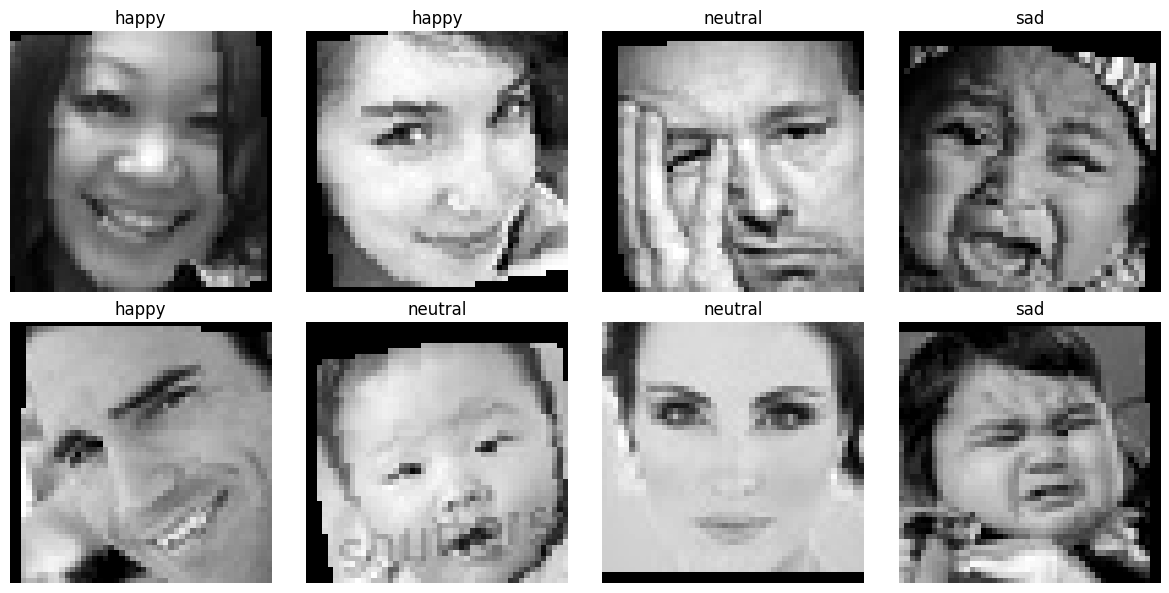

In [34]:
# visualize training samples
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5 
    img = np.clip(img, 0, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx].squeeze(), cmap='gray')
        ax.set_title(train_dataset.classes[labels[idx]])
        ax.axis('off')
plt.tight_layout()
plt.show()

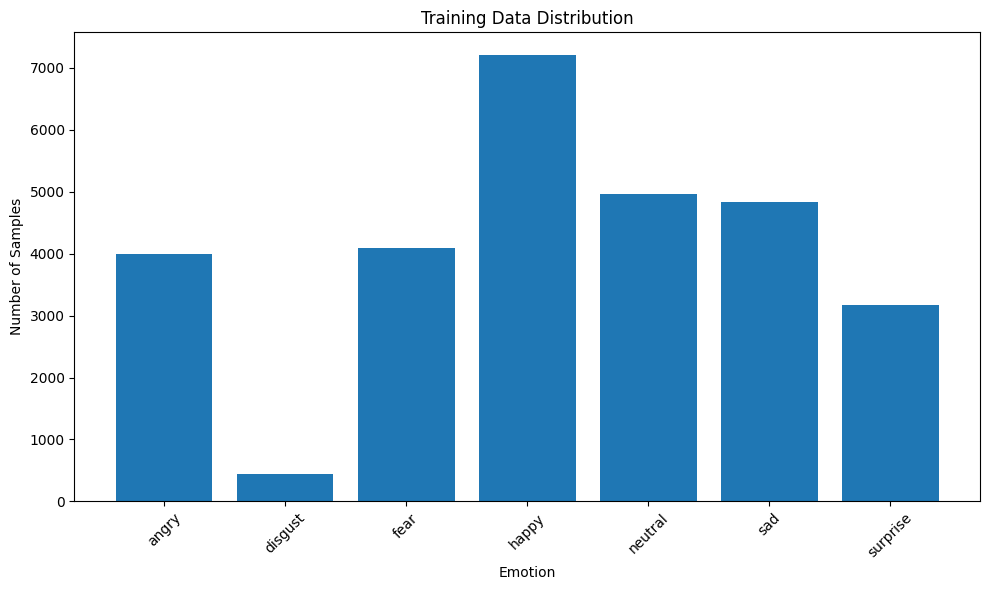

In [35]:
# count samples per class
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

plt.figure(figsize=(10, 6))
emotion_names = [train_dataset.classes[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.bar(emotion_names, counts)
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.title('Training Data Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# calculate class weights (for seeing imbalance)
total_samples = len(train_dataset)
class_weights = [total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
print("Class weights:", class_weights)

Class weights: [1.0266046844269623, 9.406618610747051, 1.0010460615781582, 0.5684387684387684, 0.8260394187886635, 0.8491274770777877, 1.293372978330405]


In [38]:
# model architecture
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

In [39]:
# initialize model
num_classes = len(train_dataset.classes)
model = EmotionCNN(num_classes=num_classes).to(device)

In [47]:
# train setup
# 1. loss function
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 2. optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 3. learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\n{'='*50}")
print(f"Training Configuration:")
print(f"{'='*50}")
print(f"Loss function: CrossEntropyLoss with class weights")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Scheduler: ReduceLROnPlateau")


Training Configuration:
Loss function: CrossEntropyLoss with class weights
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Scheduler: ReduceLROnPlateau


In [43]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [44]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [46]:
# training loop
num_epochs = 50
best_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print(f"\n{'='*50}")
print(f"Starting Training...")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # update scheduler
    scheduler.step(val_loss)
    
    # save history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx
        }, 'best_emotion_model.pth')
        print(f'✓ New best model saved!')
    
    # print progress
    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s) | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

print(f"\n{'='*50}")
print(f"Training Complete!")
print(f"{'='*50}")
print(f"Best validation accuracy: {best_acc:.2f}%")


Starting Training...

✓ New best model saved!
Epoch [1/50] (292.2s) | Train Loss: 1.9365 Acc: 20.38% | Val Loss: 1.7033 Acc: 34.48%
✓ New best model saved!
Epoch [2/50] (287.5s) | Train Loss: 1.7097 Acc: 33.23% | Val Loss: 1.5206 Acc: 40.86%
✓ New best model saved!
Epoch [3/50] (266.0s) | Train Loss: 1.5839 Acc: 39.29% | Val Loss: 1.3984 Acc: 46.52%
✓ New best model saved!
Epoch [4/50] (279.6s) | Train Loss: 1.5184 Acc: 42.07% | Val Loss: 1.3913 Acc: 47.14%
✓ New best model saved!
Epoch [5/50] (280.3s) | Train Loss: 1.4780 Acc: 43.96% | Val Loss: 1.3102 Acc: 50.43%
Epoch [6/50] (268.8s) | Train Loss: 1.4412 Acc: 45.52% | Val Loss: 1.3966 Acc: 46.14%
✓ New best model saved!
Epoch [7/50] (272.3s) | Train Loss: 1.4201 Acc: 45.98% | Val Loss: 1.2383 Acc: 52.08%
✓ New best model saved!
Epoch [8/50] (271.2s) | Train Loss: 1.3920 Acc: 47.32% | Val Loss: 1.2212 Acc: 53.44%
Epoch [9/50] (271.6s) | Train Loss: 1.3777 Acc: 47.41% | Val Loss: 1.2251 Acc: 52.77%
✓ New best model saved!
Epoch [10/5

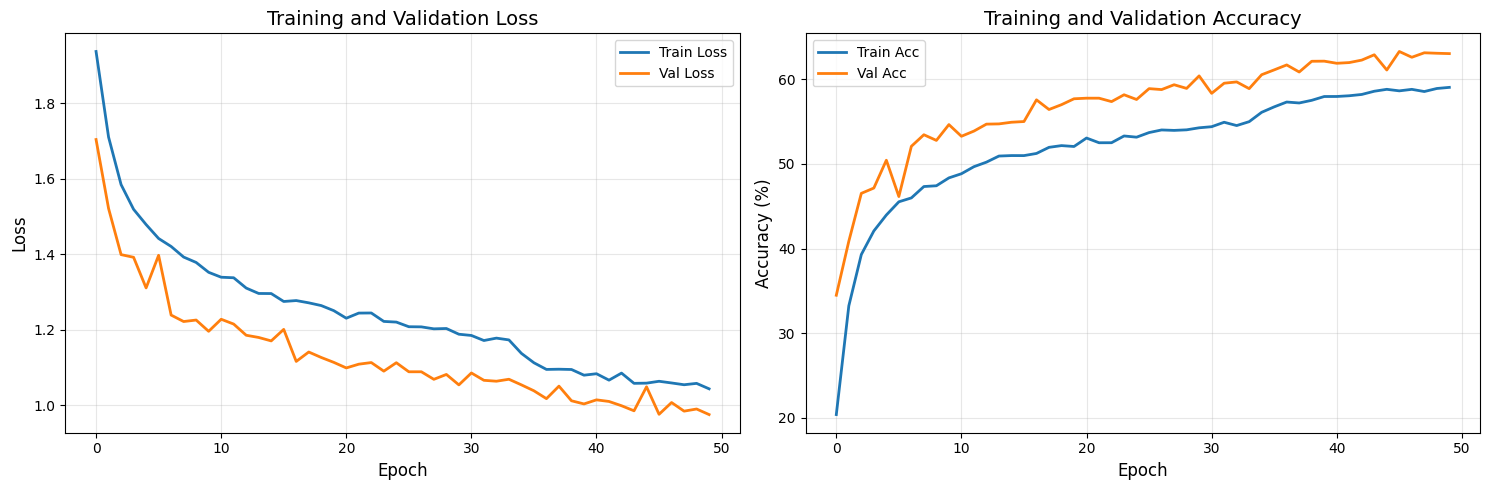

In [48]:
# plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# evaluate best model
# load best model
checkpoint = torch.load('best_emotion_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

Loaded best model from epoch 46
Best validation accuracy: 63.28%


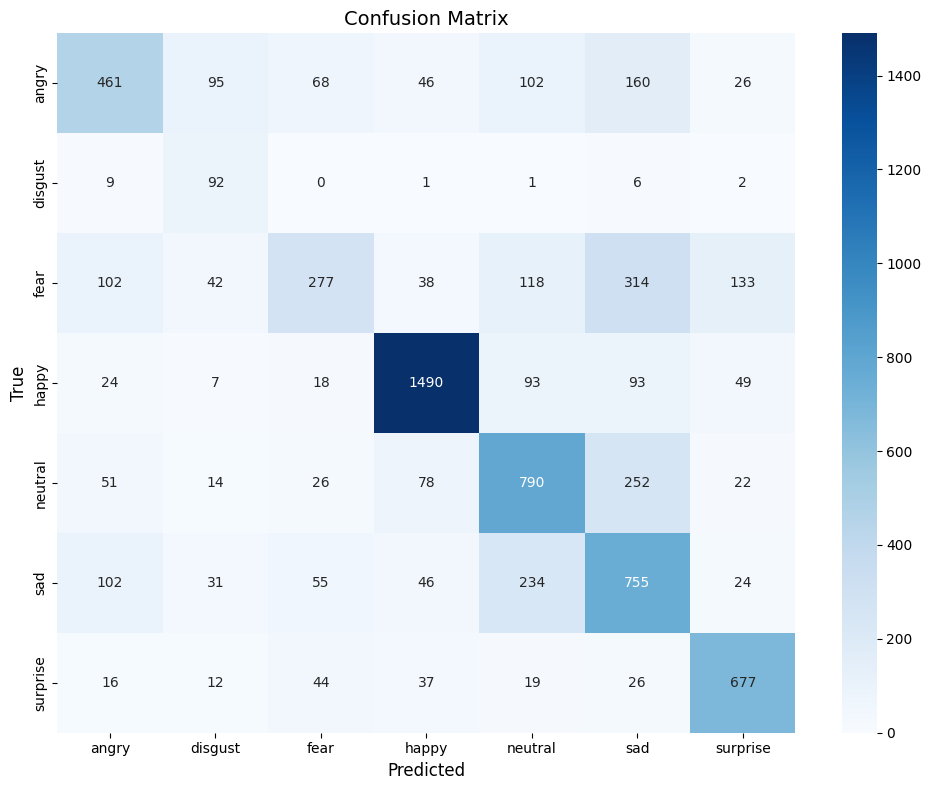

In [ ]:
# confusion matrix
def get_predictions(model, loader, device):
    """Get all predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# get predictions
preds, labels = get_predictions(model, test_loader, device)

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()


In [51]:
# classification report
print(f"\n{'='*50}")
print(f"Classification Report:")
print(f"{'='*50}\n")
print(classification_report(labels, preds, target_names=train_dataset.classes))


Classification Report:

              precision    recall  f1-score   support

       angry       0.60      0.48      0.54       958
     disgust       0.31      0.83      0.46       111
        fear       0.57      0.27      0.37      1024
       happy       0.86      0.84      0.85      1774
     neutral       0.58      0.64      0.61      1233
         sad       0.47      0.61      0.53      1247
    surprise       0.73      0.81      0.77       831

    accuracy                           0.63      7178
   macro avg       0.59      0.64      0.59      7178
weighted avg       0.64      0.63      0.63      7178



In [ ]:
# visualize predictions
def visualize_predictions(model, dataset, device, num_samples=16):
    """Visualize model predictions"""
    model.eval()
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_samples:
            # get random sample
            sample_idx = np.random.randint(len(dataset))
            img, true_label = dataset[sample_idx]
            
            # predict
            with torch.no_grad():
                img_input = img.unsqueeze(0).to(device)
                output = model(img_input)
                probabilities = torch.softmax(output, dim=1)
                pred_label = output.argmax(1).item()
                confidence = probabilities[0][pred_label].item()
            
            # display
            img_display = img.numpy().squeeze()
            img_display = img_display * 0.5 + 0.5
            img_display = np.clip(img_display, 0, 1)
            
            ax.imshow(img_display, cmap='gray')
            
            true_name = dataset.classes[true_label]
            pred_name = dataset.classes[pred_label]
            
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_name}\nPred: {pred_name} ({confidence:.2f})',
                        color=color, fontsize=9)
            ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', 
                 fontsize=14, y=1.002)
    plt.show()

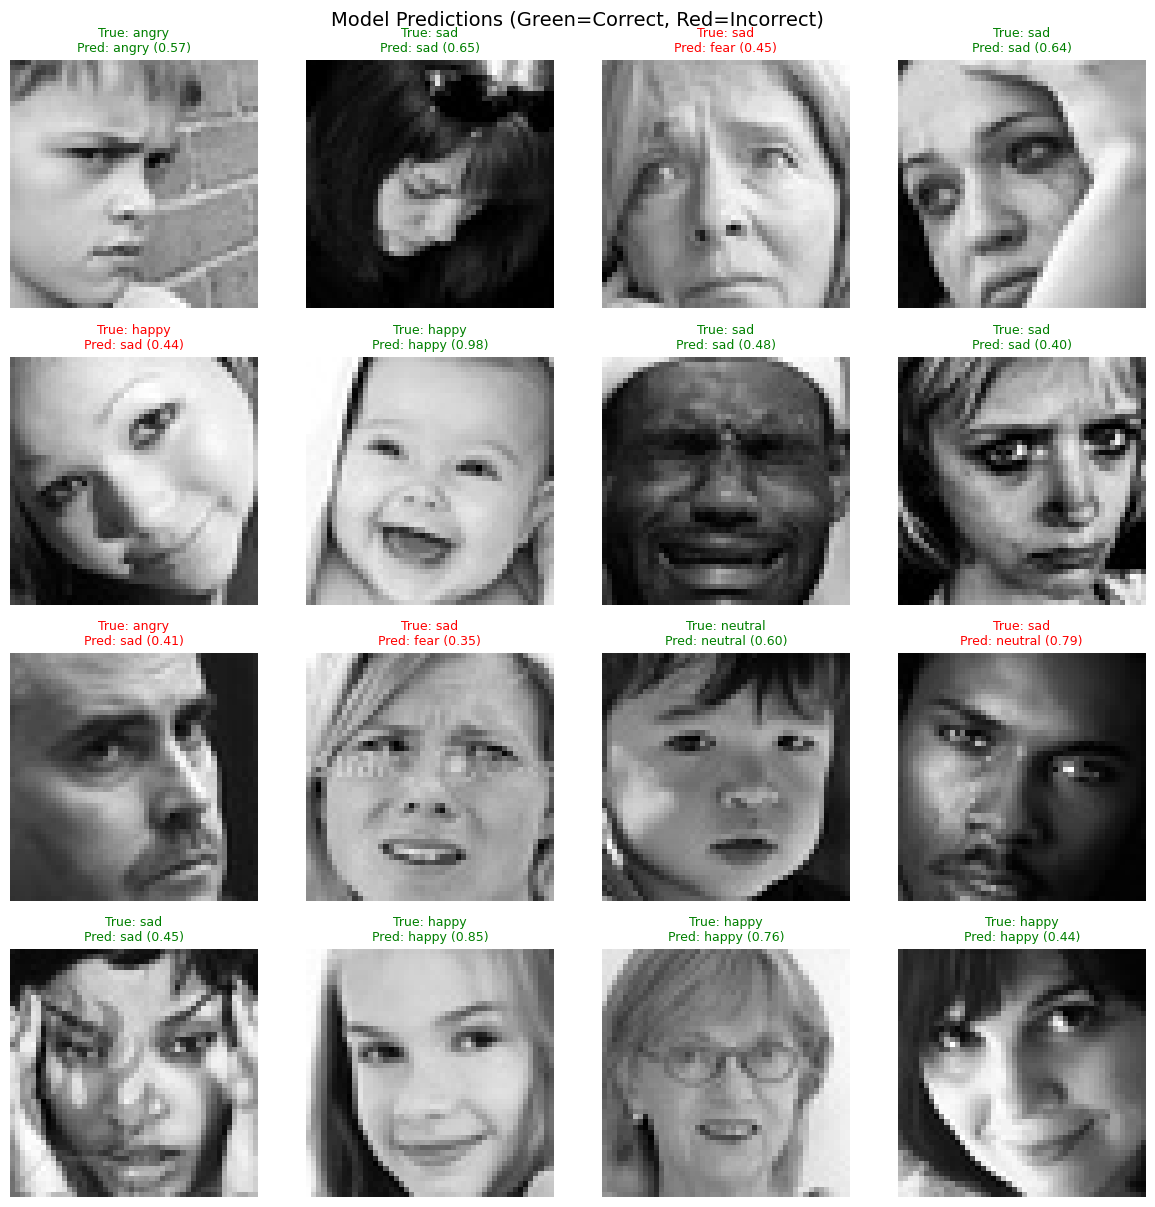

In [55]:
visualize_predictions(model, test_dataset, device, num_samples=16)

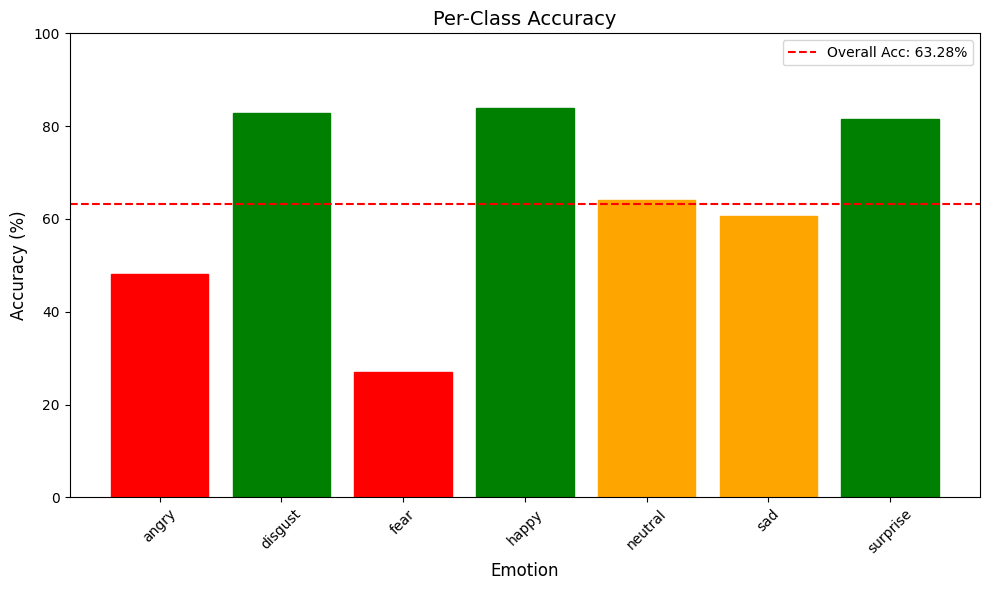

In [56]:
# per class accuracy
per_class_correct = np.zeros(num_classes)
per_class_total = np.zeros(num_classes)

for i in range(len(labels)):
    true_label = labels[i]
    pred_label = preds[i]
    
    per_class_total[true_label] += 1
    if true_label == pred_label:
        per_class_correct[true_label] += 1

per_class_acc = 100 * per_class_correct / per_class_total

plt.figure(figsize=(10, 6))
bars = plt.bar(train_dataset.classes, per_class_acc, color='skyblue')

# color bars based on accuracy
for i, bar in enumerate(bars):
    if per_class_acc[i] < 50:
        bar.set_color('red')
    elif per_class_acc[i] < 70:
        bar.set_color('orange')
    else:
        bar.set_color('green')

plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14)
plt.xticks(rotation=45)
plt.ylim([0, 100])
plt.axhline(y=best_acc, color='r', linestyle='--', label=f'Overall Acc: {best_acc:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
print(f"\n{'='*50}")
print(f"Per-Class Accuracy:")
print(f"{'='*50}")
for i, emotion in enumerate(train_dataset.classes):
    print(f"{emotion:12s}: {per_class_acc[i]:.2f}%")


Per-Class Accuracy:
angry       : 48.12%
disgust     : 82.88%
fear        : 27.05%
happy       : 83.99%
neutral     : 64.07%
sad         : 60.55%
surprise    : 81.47%


In [58]:
print(f"\n{'='*50}")
print(f"Training Summary:")
print(f"{'='*50}")
print(f"Total epochs: {num_epochs}")
print(f"Best validation accuracy: {best_acc:.2f}%")
print(f"Model saved as: best_emotion_model.pth")
print(f"\nNext steps:")
print(f"1. Experiment with different architectures (ResNet, EfficientNet)")
print(f"2. Try different hyperparameters (learning rate, batch size)")
print(f"3. Implement real-time detection with webcam")
print(f"{'='*50}\n")


Training Summary:
Total epochs: 50
Best validation accuracy: 63.28%
Model saved as: best_emotion_model.pth

Next steps:
1. Experiment with different architectures (ResNet, EfficientNet)
2. Try different hyperparameters (learning rate, batch size)
3. Implement real-time detection with webcam

